In [1]:
#from networkx import karate_club_graph, to_numpy_matrix
%matplotlib inline
import numpy as np
import networkx as nx
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt



In [3]:
#!pip install --upgrade matplotlib



In [4]:
import networkx as nx
nx.readwrite.graphml.GraphMLReader.python_type["long"] = int
G = nx.read_graphml("network.graphml")

In [5]:
G = nx.read_graphml("network.graphml")
original_labels = {i: label for i, label in enumerate(G.nodes)}
G = nx.convert_node_labels_to_integers(G)
order = np.arange(G.number_of_nodes())
A = nx.to_numpy_array(G, nodelist=order)
I = np.eye(G.number_of_nodes())

In [60]:
exported= '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_net/network.graphml'
graphml_path = exported

# Load the GraphML into a NetworkX graph object
G = nx.read_graphml(graphml_path)
#G = nx.convert_node_labels_to_integers(G)


In [33]:
# Save the original node labels
original_labels = {i: label for i, label in enumerate(G.nodes)}

# Convert node labels to integers
#G = nx.convert_node_labels_to_integers(G)

# Use the sequential integer nodes
#nodelist = list(G.nodes)
#A = nx.to_numpy_array(G, nodelist=nodelist)


In [66]:
#original_labels

In [6]:
 #Find the number corresponding to the node label "metavariable"
target_label = "covariate"
target_node_number = [node for node, label in original_labels.items() if label == target_label]

if target_node_number:
    print(f"Node number corresponding to label '{target_label}': {target_node_number[0]}")
else:
    print(f"No node found with label '{target_label}'.")


Node number corresponding to label 'covariate': 559


In [7]:
np.random.seed(7)

A_hat = A + np.eye(G.number_of_nodes()) # add self-connections

D_hat = np.array(np.sum(A_hat, axis=0))
D_hat = np.array(np.diag(D_hat))
#D_hat = np.linalg.inv(sqrtm(D_hat))
D_hat = np.linalg.inv(np.sqrt(D_hat))
A_hat = D_hat @ A_hat @ D_hat

def glorot_init(nin, nout):
  sd = np.sqrt(6.0 / (nin + nout))
  return np.random.uniform(-sd, sd, size=(nin, nout))

class GCNLayer():
  def __init__(self, n_inputs, n_outputs):
      self.n_inputs = n_inputs
      self.n_outputs = n_outputs
      self.W = glorot_init(self.n_outputs, self.n_inputs)
      self.activation = np.tanh
      
  def forward(self, A, X):
      self._X = (A @ X).T # (N,N)*(N,n_outputs) ==> (n_outputs,N)
      H = self.W @ self._X # (N, D)*(D, n_outputs) => (N, n_outputs)
      H = self.activation(H)
      return H.T # (n_outputs, N)

gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)

H1 = gcn1.forward(A_hat, I)
H2 = gcn2.forward(A_hat, H1)
H3 = gcn3.forward(A_hat, H2)

embeddings = H3

C:\Users\z5355245\Anaconda3\envs\spieceasi\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


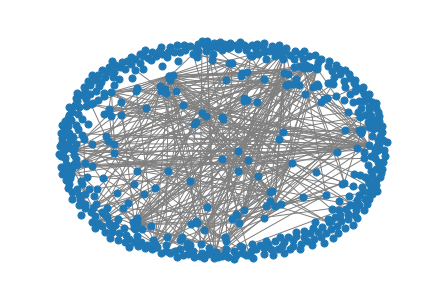

In [8]:
def draw_graph(G, filename=None, node_size=50):
  pos_nodes = nx.spring_layout(G)
  nx.draw(G, pos_nodes, with_labels=False, node_size=node_size, edge_color='gray')
  
  pos_attrs = {}
  for node, coords in pos_nodes.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)

  plt.axis('off')
  axis = plt.gca()
  axis.set_xlim([1.2*x for x in axis.get_xlim()])
  axis.set_ylim([1.2*y for y in axis.get_ylim()])

embeddings = np.array(embeddings)
draw_graph(G)

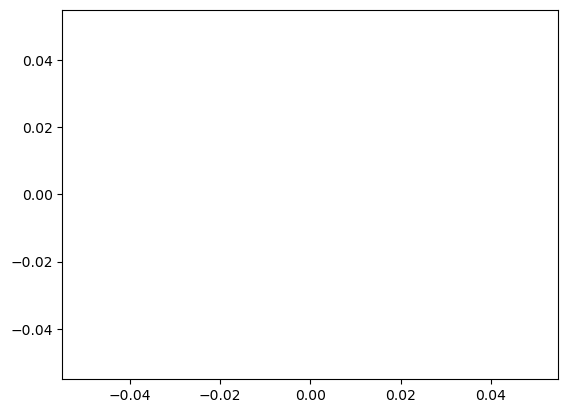

In [28]:
plt.scatter(embeddings[:, 0], embeddings[:, 1])
#plt.savefig('embedding_gcn.png',dpi=300)

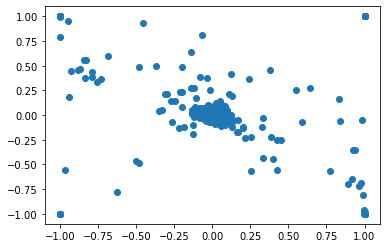

In [9]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

np.random.seed(7)

# Ensure A_hat is normalized correctly
A_hat = A + np.eye(G.number_of_nodes())  # Add self-connections

# Calculate degree matrix
D_hat = np.diag(np.sum(A_hat, axis=0))
D_hat = np.maximum(D_hat, 1e-10)  # Handle zero or negative degrees
D_hat = np.linalg.inv(np.diag(np.sqrt(np.diag(D_hat))))  # Normalize

A_hat = D_hat @ A_hat @ D_hat

def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

class GCNLayer:
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = np.tanh
        
    def forward(self, A, X):
        self._X = (A @ X).T  # (N, N) * (N, n_outputs) ==> (n_outputs, N)
        H = self.W @ self._X  # (N, D) * (D, n_outputs) => (N, n_outputs)
        H = self.activation(H)
        return H.T  # (n_outputs, N)

gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)

I = np.eye(G.number_of_nodes())  # Identity matrix

H1 = gcn1.forward(A_hat, I)
H2 = gcn2.forward(A_hat, H1)
H3 = gcn3.forward(A_hat, H2)

# Ensure embeddings are real
embeddings = np.real(H3)

plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.show()


In [12]:
distances.mean()

1.4955997331864122

Nodes classified as 'DA': [62, 129, 241, 258, 559]


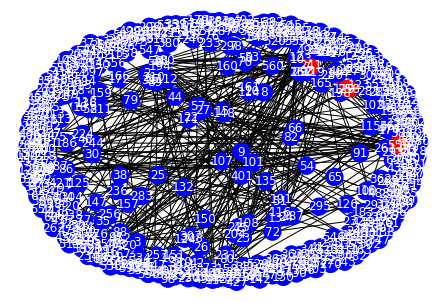

In [11]:
from scipy.spatial.distance import cdist

# Step 1: Choose the target node (e.g., node index 0)
target_node = target_node_number

# Step 2: Compute pairwise distances in the embedding space
distances = cdist(embeddings, embeddings[target_node].reshape(1, -1), metric='euclidean').flatten()

# Step 3: Define a threshold
threshold = 0.05#distances.mean()  # Example: mean distance as threshold

# Step 4: Classify nodes
labels = np.where(distances <= threshold, "DA", "non-DA")

# Step 5: Collect nodes classified as "DA"
da_nodes = [node for node, label in enumerate(labels) if label == "DA"]

print("Nodes classified as 'DA':", da_nodes)

# Optional: Visualize the DA nodes
node_colors = ["red" if node in da_nodes else "blue" for node in range(G.number_of_nodes())]
nx.draw(
    G, 
    with_labels=True, 
    node_color=node_colors, 
    cmap=plt.cm.Set1, 
    font_color="white"
)
plt.show()


In [13]:
#da_nodes

In [13]:
dalist= [original_labels.get(num, "Label not found") for num in da_nodes]

In [14]:
len(dalist)

5

In [96]:
import pandas as pd

# Load CSV files into Python
df = pd.read_csv("graph_ANCOM-BC_dataset1_sample3.csv",index_col=0)

In [25]:
#df

In [97]:
ancombc = df.index[df["pred"] == "DA"].tolist()

In [21]:
#ancombc

In [98]:
common_elements = list(set(ancombc) & set(dalist))

In [99]:
common_elements

['TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGCTGGCAAGTCAGGCGTGAAATCCCAGGGCTCAACCCTGGAACTGCGTTTGAAACTGCTGGTCTTGAGTACCGGAGAGGTCATCGGAATTCCTTG',
 'TACGTAGGTGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGACTGCAAGTCAGATGTGAAAACCATGGGCTCAACCTGTGGCCTGCATTTGAAACTGTAGTTCTTGAGTACTGGAGAGGCAGACGGAATTCCTAG']

In [100]:
truth = df.index[df["truth"] == "DA"].tolist()

In [101]:
common_elements_truth = list(set(truth) & set(dalist))

In [103]:
len(common_elements_truth)

0

In [104]:
common_elements_truth_accombc = list(set(ancombc) & set(truth))

In [105]:
len(common_elements_truth_accombc)

7

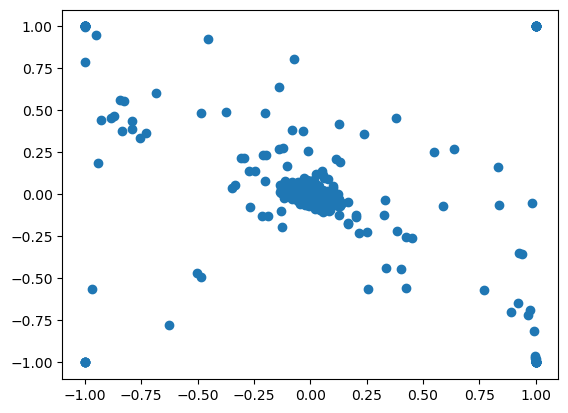

In [41]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

np.random.seed(7)

# Ensure A_hat is normalized correctly
A_hat = A + np.eye(G.number_of_nodes())  # Add self-connections

# Calculate degree matrix
D_hat = np.diag(np.sum(A_hat, axis=0))
D_hat = np.maximum(D_hat, 1e-10)  # Handle zero or negative degrees
D_hat = np.linalg.inv(np.diag(np.sqrt(np.diag(D_hat))))  # Normalize

A_hat = D_hat @ A_hat @ D_hat

def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

class GCNLayer:
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = np.tanh
        
    def forward(self, A, X):
        self._X = (A @ X).T  # (N, N) * (N, n_outputs) ==> (n_outputs, N)
        H = self.W @ self._X  # (N, D) * (D, n_outputs) => (N, n_outputs)
        H = self.activation(H)
        return H.T  # (n_outputs, N)

gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)

I = np.eye(G.number_of_nodes())  # Identity matrix

H1 = gcn1.forward(A_hat, I)
H2 = gcn2.forward(A_hat, H1)
H3 = gcn3.forward(A_hat, H2)

# Ensure embeddings are real
embeddings = np.real(H3)

plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.show()


Autoencoder:  
Structural Deep Network Embedding

In [16]:
import tensorflow as tf
from gem.embedding.sdne import SDNE
import networkx as nx

In [126]:
#!pip install git+https://github.com/palash1992/GEM.git

!pip install networkx==2.5


In [17]:
m1 = SDNE(d=2, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, K=3,n_units=[50, 15,], rho=0.3, n_iter=10, 
          xeta=0.01,n_batch=50,
          modelfile=['enc_model.json', 'dec_model.json'],
          weightfile=['enc_weights.hdf5', 'dec_weights.hdf5'])

In [19]:
embeddings=m1.learn_embedding(G)

C:\Users\z5355245\Anaconda3\envs\spieceasi\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
C:\Users\z5355245\Anaconda3\envs\spieceasi\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
16/16 [==============================] - 3s 8ms/step - loss: 13.4039 - subtract_3_loss: 6.6784 - subtract_4_loss: 6.7223 - subtract_5_loss: 3.6231e-04
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 13.0100 - subtract_3_loss: 6.5094 - subtract_4_loss: 6.4973 - subtract_5_loss: 2.3098e-04
Epoch 3/10
16/16 [==============================] - 0s 7ms/step - loss: 12.8361 - subtract_3_loss: 6.4212 - subtract_4_loss: 6.4116 - subtract_5_loss: 0.0000e+00
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 12.7428 - subtract_3_loss: 6.3741 - subtract_4_loss: 6.3654 - subtract_5_loss: 0.0000e+00
Epoch 5/10
16/16 [==============================] - 0s 9ms/step - loss: 12.7564 - subtract_3_loss: 6.3778 - subtract_4_loss: 6.3753 - subtract_5_loss: 0.0000e+00
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 12.7096 - subtract_3_loss: 6.3512 - subtract_4_loss: 6.3551 - subtract_5_loss: 0.0000e+00
Epoch 7/10
16/16 [==========

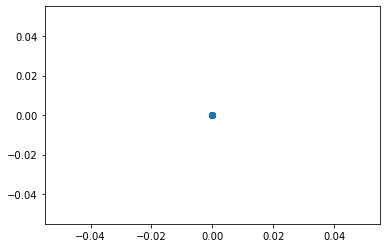

In [21]:
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.show()

Nodes classified as 'DA': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216

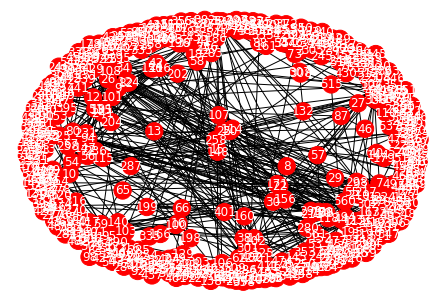

In [22]:
from scipy.spatial.distance import cdist

# Step 1: Choose the target node (e.g., node index 0)
target_node = target_node_number

# Step 2: Compute pairwise distances in the embedding space
distances = cdist(embeddings, embeddings[target_node].reshape(1, -1), metric='euclidean').flatten()

# Step 3: Define a threshold
threshold = 0.01#distances.mean()  # Example: mean distance as threshold

# Step 4: Classify nodes
labels = np.where(distances <= threshold, "DA", "non-DA")

# Step 5: Collect nodes classified as "DA"
da_nodes = [node for node, label in enumerate(labels) if label == "DA"]

print("Nodes classified as 'DA':", da_nodes)

# Optional: Visualize the DA nodes
node_colors = ["red" if node in da_nodes else "blue" for node in range(G.number_of_nodes())]
nx.draw(
    G, 
    with_labels=True, 
    node_color=node_colors, 
    cmap=plt.cm.Set1, 
    font_color="white"
)
plt.show()
